In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Rock17st@r"
                             ,
                            database = "ecommerce")
cur = db.cursor()

# Calculate the moving average of order values for each customer over their order history

In [7]:
query = """ SELECT 
    *, 
    AVG(payment) OVER (
        PARTITION BY customer_id 
        ORDER BY order_purchase_timestamp 
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM (
    SELECT 
        orders.customer_id, 
        orders.order_purchase_timestamp, 
        payments.payment_value AS payment
    FROM 
        payments
    JOIN 
        orders 
        ON payments.order_id = orders.order_id
) AS customer_payments;
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id", "Time_Stamp", "Payment", "Moving_avg"])
df.head()


,Customer_id,Time_Stamp,Payment,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year

In [12]:
query = """ SELECT 
    *, 
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        MONTH(orders.order_purchase_timestamp) AS months,
        SUM(payments.payment_value) AS payment
    FROM 
        orders
    JOIN 
        payments 
        ON orders.order_id = payments.order_id
    GROUP BY 
        years, months
    ORDER BY 
        years, months
) AS monthly_sales;
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Months", "Sales", "Cumilative_sales"])
df.head()

,Years,Months,Sales,Cumilative_sales
0,2016,9,252.239994,252.239994
1,2016,10,59090.479999,59342.719993
2,2016,12,19.620001,59362.339994
3,2017,1,138488.040064,197850.380058
4,2017,2,291908.009507,489758.389565


# Calculate the year-over-year growth rate of total sales.

In [6]:
query = """
SELECT 
    *, 
    SUM(payment) OVER (ORDER BY years) AS cumulative_sales,
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
    LAG(payment, 1) OVER (ORDER BY years)) * 100 AS yoy_growth
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM 
        orders
    JOIN 
        payments 
        ON orders.order_id = payments.order_id
    GROUP BY 
        years
    ORDER BY 
        years
) AS yearly_sales;
 """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["YEARS", "SALES","CUMILATIVE_SALES","%YOY%GROWTH"])
df

,YEARS,SALES,CUMILATIVE_SALES,%YOY%GROWTH
0,2016,59362.34,59362.34,NaN
1,2017,7249746.73,7309109.07,12112.703761
2,2018,8699763.05,16008872.12,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [9]:
query = """ WITH a AS (
    SELECT 
        customers.customer_id, 
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers
    JOIN 
        orders 
        ON customers.customer_id = orders.customer_id
    GROUP BY 
        customers.customer_id
),
b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS repeat_orders
    FROM 
        a
    JOIN 
        orders 
        ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
)
SELECT 
    (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) * 100 AS percentage
FROM 
    a
LEFT JOIN 
    b 
    ON a.customer_id = b.customer_id;
 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


# Identify the top 3 customers who spent the most money in each year

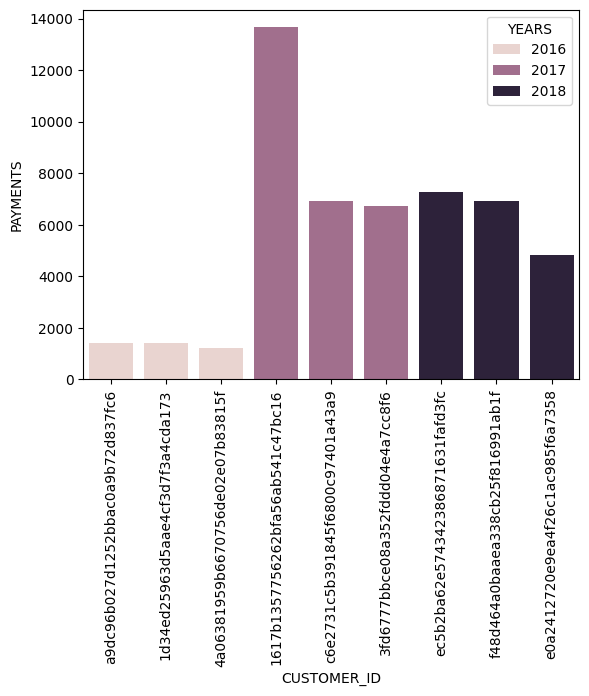

In [11]:
query = """ SELECT 
    years, 
    customer_id, 
    payment, 
    d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years, 
        orders.customer_id, 
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp) 
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders
    JOIN 
        payments 
        ON orders.order_id = payments.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp), 
        orders.customer_id
) AS ranked_customers
WHERE 
    d_rank <= 3; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["YEARS","CUSTOMER_ID","PAYMENTS","RANK"])
# df
sns.barplot(x= "CUSTOMER_ID", y = "PAYMENTS", data = df , hue= "YEARS")
plt.xticks(rotation= 90)
plt.show()